In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
wd=os.getcwd()
print('Current Directory:',wd)

Current Directory: C:\Users\fabrizioxueling\B9FT106 Applied Financial Analysis\Final Files


In [2]:
import pandas as pd
import numpy as np

In [3]:
import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import sklearn.decomposition as sck_dec

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline
sns.set_style("white")
#plt.style.use('ggplot')

from IPython.display import display, HTML, Image

## Import the ECB dataset:

### 1 - First file, data until the end of 2018

In [6]:
# import data
# --> REPLACE WITH PATH WITH THE LOCATION OF YOUR FILE!!!!
ecb_yc=pd.read_csv('C:/Users/fabrizioxueling/B9FT106 Applied Financial Analysis/Dataset/data_extended.csv') # --> REPLACE WITH PATH WITH THE LOCATION OF YOUR FILE!!!!
print('Dataset shape - rows: {}, columns: {}'.format(ecb_yc.shape[0],ecb_yc.shape[1]))

ecb_yc.head(2)

Dataset shape - rows: 3966324, columns: 40


,KEY,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM,TIME_PERIOD,OBS_VALUE,...,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT
0,YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_A,SV_C_YM,BETA0,2004-09-06,5.410510,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
1,YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_A,SV_C_YM,BETA0,2004-09-07,5.391886,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0


In [7]:
# Format the data:

ecb_yc_sub = ecb_yc[['DATA_TYPE_FM','TIME_PERIOD','OBS_VALUE']]
ecb_yc_sub['TIME_PERIOD'] = pd.to_datetime( ecb_yc_sub['TIME_PERIOD'], format= '%Y-%m-%d' )
ecb_yc_sub.set_index('TIME_PERIOD',inplace=True)

In [8]:
ecb_yc_sub.head(5)

,DATA_TYPE_FM,OBS_VALUE
TIME_PERIOD,,
2004-09-06,BETA0,5.410510
2004-09-07,BETA0,5.391886
2004-09-08,BETA0,5.385978
2004-09-09,BETA0,5.377333
2004-09-10,BETA0,5.355732


In [9]:
list(ecb_yc_sub['DATA_TYPE_FM'].unique())[:20]

['BETA0',
 'BETA1',
 'BETA2',
 'BETA3',
 'IF_10M',
 'IF_10Y',
 'IF_10Y10M',
 'IF_10Y11M',
 'IF_10Y1M',
 'IF_10Y2M',
 'IF_10Y3M',
 'IF_10Y4M',
 'IF_10Y5M',
 'IF_10Y6M',
 'IF_10Y7M',
 'IF_10Y8M',
 'IF_10Y9M',
 'IF_11M',
 'IF_11Y',
 'IF_11Y10M']

In [10]:
# define function for create a filter:
def extract_yield_type(data):
    return (data[0:3])

# apply this function:
ecb_yc_sub['Yield_Type']=ecb_yc_sub['DATA_TYPE_FM'].apply( extract_yield_type )
ecb_yc_sub.head(5)

,DATA_TYPE_FM,OBS_VALUE,Yield_Type
TIME_PERIOD,,,
2004-09-06,BETA0,5.410510,BET
2004-09-07,BETA0,5.391886,BET
2004-09-08,BETA0,5.385978,BET
2004-09-09,BETA0,5.377333,BET
2004-09-10,BETA0,5.355732,BET


In [11]:
# Filter for spot rates:
ecb_yc_sr=ecb_yc_sub[ecb_yc_sub['Yield_Type'] == 'SR_'].copy()
display(ecb_yc_sr.head(3))
print('Dataset shape - rows: {}, columns: {}'.format(ecb_yc_sr.shape[0],ecb_yc_sr.shape[1]))

,DATA_TYPE_FM,OBS_VALUE,Yield_Type
TIME_PERIOD,,,
2004-09-06,SR_10M,2.239924,SR_
2004-09-07,SR_10M,2.266495,SR_
2004-09-08,SR_10M,2.281809,SR_


Dataset shape - rows: 1311712, columns: 3


In [12]:
# Check all the available tenors:
tenors = ecb_yc_sr['DATA_TYPE_FM'].unique()
print('Total Number of Tenors:',len(tenors))
print(tenors)

Total Number of Tenors: 358
['SR_10M' 'SR_10Y' 'SR_10Y10M' 'SR_10Y11M' 'SR_10Y1M' 'SR_10Y2M'
 'SR_10Y3M' 'SR_10Y4M' 'SR_10Y5M' 'SR_10Y6M' 'SR_10Y7M' 'SR_10Y8M'
 'SR_10Y9M' 'SR_11M' 'SR_11Y' 'SR_11Y10M' 'SR_11Y11M' 'SR_11Y1M'
 'SR_11Y2M' 'SR_11Y3M' 'SR_11Y4M' 'SR_11Y5M' 'SR_11Y6M' 'SR_11Y7M'
 'SR_11Y8M' 'SR_11Y9M' 'SR_12Y' 'SR_12Y10M' 'SR_12Y11M' 'SR_12Y1M'
 'SR_12Y2M' 'SR_12Y3M' 'SR_12Y4M' 'SR_12Y5M' 'SR_12Y6M' 'SR_12Y7M'
 'SR_12Y8M' 'SR_12Y9M' 'SR_13Y' 'SR_13Y10M' 'SR_13Y11M' 'SR_13Y1M'
 'SR_13Y2M' 'SR_13Y3M' 'SR_13Y4M' 'SR_13Y5M' 'SR_13Y6M' 'SR_13Y7M'
 'SR_13Y8M' 'SR_13Y9M' 'SR_14Y' 'SR_14Y10M' 'SR_14Y11M' 'SR_14Y1M'
 'SR_14Y2M' 'SR_14Y3M' 'SR_14Y4M' 'SR_14Y5M' 'SR_14Y6M' 'SR_14Y7M'
 'SR_14Y8M' 'SR_14Y9M' 'SR_15Y' 'SR_15Y10M' 'SR_15Y11M' 'SR_15Y1M'
 'SR_15Y2M' 'SR_15Y3M' 'SR_15Y4M' 'SR_15Y5M' 'SR_15Y6M' 'SR_15Y7M'
 'SR_15Y8M' 'SR_15Y9M' 'SR_16Y' 'SR_16Y10M' 'SR_16Y11M' 'SR_16Y1M'
 'SR_16Y2M' 'SR_16Y3M' 'SR_16Y4M' 'SR_16Y5M' 'SR_16Y6M' 'SR_16Y7M'
 'SR_16Y8M' 'SR_16Y9M' 'SR_17Y' 'SR_17

#### Esplorative Data Analysis:

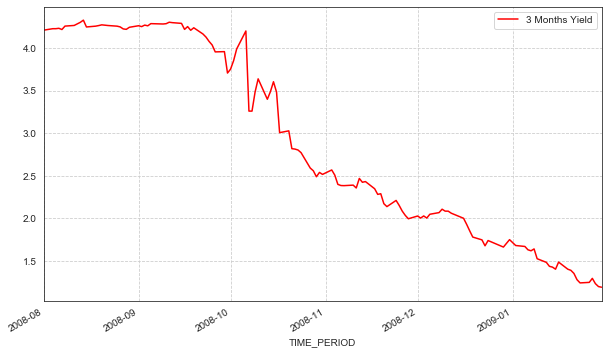

In [13]:
yields_3m = ecb_yc_sr[ecb_yc_sr['DATA_TYPE_FM']=='SR_3M']
yields_3m.loc['2008-08':'2009-01','OBS_VALUE'].plot(figsize=(10,6),color='r')
plt.grid(linestyle='--')
plt.legend((['3 Months Yield']));

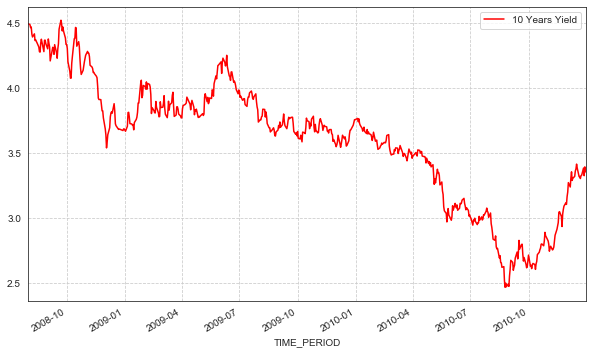

In [14]:
yields_10y = ecb_yc_sr[ecb_yc_sr['DATA_TYPE_FM']=='SR_10Y']
yields_10y.loc['2008-08':'2010-12','OBS_VALUE'].plot(figsize=(10,6),color='r')
plt.grid(linestyle='--')
plt.legend((['10 Years Yield']));

#### Extract the Yield Curve by sorting the dataset by maturities

In [15]:
# Define list of yearly Maturities
maturities=list(range(1,31))

In [16]:
# Define list of Monthly Maturities:
time = [str(i)+'M' for i in range(3,12)]
time_float = [i/12 for i in range(3,12)]
yield_df_columns_names = ['Yield {}M'.format(i) for i in range(3,12)]

In [17]:
# Now Add the Yearly Maturities:
for i in maturities:
    time.append(str(i)+'Y')
    time_float.append(i)
    yield_df_columns_names.append('Yield {}Y'.format(i))

In [21]:
yields_df_0 = pd.DataFrame(index = yields_3m.index, columns = yield_df_columns_names)

# Fill the DataFrame:

for i in range(0,len(time)):
    
    maturity = time[i]
    yield_name = 'Yield '+ maturity
    yields_df_0[yield_name] = ecb_yc_sr[ecb_yc_sr['DATA_TYPE_FM']=='SR_'+maturity]['OBS_VALUE']
    
display(yields_df_0.head())   
display(yields_df_0.tail()) 
print('Dataset shape - rows: {}, columns: {}'.format(yields_df_0.shape[0],yields_df_0.shape[1]))

,Yield 3M,Yield 4M,Yield 5M,Yield 6M,Yield 7M,Yield 8M,Yield 9M,Yield 10M,Yield 11M,Yield 1Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2004-09-06,2.034172,2.063283,2.092544,2.121920,2.151377,2.180882,2.210407,2.239924,2.269409,2.298838,...,4.808953,4.836016,4.860795,4.883558,4.904536,4.923925,4.941896,4.958596,4.974153,4.988680
2004-09-07,2.040893,2.073717,2.106364,2.138822,2.171075,2.203112,2.234922,2.266495,2.297820,2.328891,...,4.798185,4.824870,4.849308,4.871763,4.892459,4.911590,4.929323,4.945804,4.961158,4.975495
2004-09-08,2.044384,2.079252,2.113815,2.148064,2.181994,2.215598,2.248871,2.281809,2.314408,2.346666,...,4.805488,4.831593,4.855497,4.877459,4.897700,4.916408,4.933749,4.949863,4.964876,4.978894
2004-09-09,2.037111,2.067808,2.098422,2.128935,2.159329,2.189588,2.219696,2.249641,2.279409,2.308988,...,4.763395,4.790922,4.816145,4.839332,4.860711,4.880479,4.898808,4.915844,4.931719,4.946545
2004-09-10,2.034645,2.060137,2.085928,2.111976,2.138239,2.164681,2.191267,2.217962,2.244738,2.271566,...,4.732636,4.760578,4.786181,4.809716,4.831415,4.851478,4.870080,4.887372,4.903483,4.918530


,Yield 3M,Yield 4M,Yield 5M,Yield 6M,Yield 7M,Yield 8M,Yield 9M,Yield 10M,Yield 11M,Yield 1Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2018-12-19,-0.799995,-0.796208,-0.791908,-0.787119,-0.781865,-0.776170,-0.770056,-0.763545,-0.756658,-0.749415,...,0.816881,0.840622,0.862361,0.882329,0.900728,0.917730,0.933484,0.948121,0.961755,0.974482
2018-12-20,-0.804300,-0.800028,-0.795279,-0.790076,-0.784442,-0.778399,-0.771968,-0.765170,-0.758024,-0.750549,...,0.784100,0.807273,0.828495,0.847990,0.865954,0.882556,0.897941,0.912236,0.925550,0.937981
2018-12-21,-0.800143,-0.797267,-0.793812,-0.789807,-0.785280,-0.780256,-0.774761,-0.768819,-0.762454,-0.755688,...,0.804715,0.827666,0.848659,0.867926,0.885665,0.902049,0.917224,0.931317,0.944439,0.956687
2018-12-27,-0.802675,-0.796572,-0.790554,-0.784578,-0.778606,-0.772604,-0.766543,-0.760396,-0.754141,-0.747759,...,0.803381,0.825290,0.845306,0.863661,0.880551,0.896145,0.910584,0.923994,0.936479,0.948132
2018-12-28,-0.802893,-0.796992,-0.791149,-0.785323,-0.779478,-0.773583,-0.767609,-0.761532,-0.755330,-0.748986,...,0.824449,0.846767,0.867156,0.885854,0.903061,0.918946,0.933656,0.947317,0.960036,0.971907


Dataset shape - rows: 3664, columns: 39


### 2 - Seconf file, data 2019:

In [22]:
# import data
# import data
# --> REPLACE WITH PATH WITH THE LOCATION OF YOUR FILE!!!!
ecb_yc_1=pd.read_csv('C:/Users/fabrizioxueling/B9FT106 Applied Financial Analysis/Dataset/data.csv')
print('Dataset shape - rows: {}, columns: {}'.format(ecb_yc_1.shape[0],ecb_yc_1.shape[1]))

ecb_yc_1.head(2)

Dataset shape - rows: 220932, columns: 40


,KEY,FREQ,REF_AREA,CURRENCY,PROVIDER_FM,INSTRUMENT_FM,PROVIDER_FM_ID,DATA_TYPE_FM,TIME_PERIOD,OBS_VALUE,...,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT
0,YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_A,SV_C_YM,BETA0,2019-01-02,1.221214,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0
1,YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0,B,U2,EUR,4F,G_N_A,SV_C_YM,BETA0,2019-01-03,1.256046,...,NaN,NaN,NaN,6,NaN,NaN,"Yield curve parameters, Beta 0 - Government bo...",Euro area (changing composition) - Government ...,PURE_NUMB,0


In [23]:
# Format the data:
ecb_yc_sub_1 = ecb_yc_1[['DATA_TYPE_FM','TIME_PERIOD','OBS_VALUE']]
ecb_yc_sub_1['TIME_PERIOD'] = pd.to_datetime( ecb_yc_sub_1['TIME_PERIOD'], format= '%Y-%m-%d' )
ecb_yc_sub_1.set_index('TIME_PERIOD',inplace=True)

In [24]:
ecb_yc_sub_1.head(5)

,DATA_TYPE_FM,OBS_VALUE
TIME_PERIOD,,
2019-01-02,BETA0,1.221214
2019-01-03,BETA0,1.256046
2019-01-04,BETA0,1.274416
2019-01-07,BETA0,1.287881
2019-01-08,BETA0,1.303676


In [25]:
# apply this function:
ecb_yc_sub_1['Yield_Type']=ecb_yc_sub_1['DATA_TYPE_FM'].apply( extract_yield_type )
ecb_yc_sub_1.head(5)

,DATA_TYPE_FM,OBS_VALUE,Yield_Type
TIME_PERIOD,,,
2019-01-02,BETA0,1.221214,BET
2019-01-03,BETA0,1.256046,BET
2019-01-04,BETA0,1.274416,BET
2019-01-07,BETA0,1.287881,BET
2019-01-08,BETA0,1.303676,BET


In [26]:
# Filter for spot rates:
ecb_yc_sr_1=ecb_yc_sub_1[ecb_yc_sub_1['Yield_Type'] == 'SR_'].copy()
display(ecb_yc_sr_1.head(3))
print('Dataset shape - rows: {}, columns: {}'.format(ecb_yc_sr_1.shape[0],ecb_yc_sr_1.shape[1]))

,DATA_TYPE_FM,OBS_VALUE,Yield_Type
TIME_PERIOD,,,
2019-01-02,SR_10M,-0.681531,SR_
2019-01-03,SR_10M,-0.666331,SR_
2019-01-04,SR_10M,-0.656428,SR_


Dataset shape - rows: 73032, columns: 3


In [27]:
# Check all the available tenors:
tenors = ecb_yc_sr_1['DATA_TYPE_FM'].unique()
print('Total Number of Tenors:',len(tenors))

Total Number of Tenors: 358


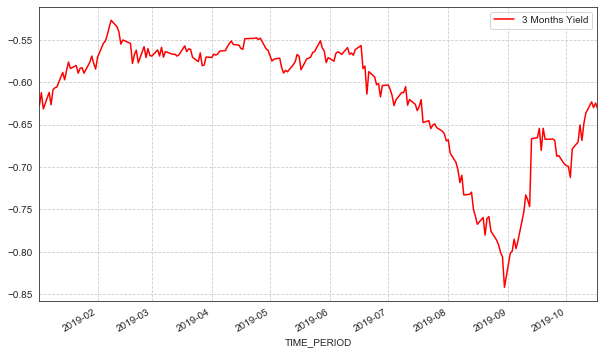

In [28]:
yields_3m = ecb_yc_sr_1[ecb_yc_sr_1['DATA_TYPE_FM']=='SR_3M']
yields_3m.loc[:,'OBS_VALUE'].plot(figsize=(10,6),color='r')
plt.grid(linestyle='--')
plt.legend((['3 Months Yield']));

#### Extract the Yield Curve by sorting the dataset by maturities

In [29]:
# Define list of yearly Maturities
maturities=list(range(1,31))

In [30]:
# Define list of Monthly Maturities:
time = [str(i)+'M' for i in range(3,12)]
time_float = [i/12 for i in range(3,12)]
yield_df_columns_names = ['Yield {}M'.format(i) for i in range(3,12)]

In [31]:
# Now Add the Yearly Maturities:
for i in maturities:
    time.append(str(i)+'Y')
    time_float.append(i)
    yield_df_columns_names.append('Yield {}Y'.format(i))

In [32]:
yields_df_1 = pd.DataFrame(index = yields_3m.index, columns = yield_df_columns_names)

# Fill the DataFrame:
for i in range(0,len(time)):
    
    maturity = time[i]
    yield_name = 'Yield '+ maturity
    yields_df_1[yield_name] = ecb_yc_sr_1[ecb_yc_sr_1['DATA_TYPE_FM']=='SR_'+maturity]['OBS_VALUE']
    
display(yields_df_1.head())   
print('Dataset shape - rows: {}, columns: {}'.format(yields_df_1.shape[0],yields_df_1.shape[1]))

,Yield 3M,Yield 4M,Yield 5M,Yield 6M,Yield 7M,Yield 8M,Yield 9M,Yield 10M,Yield 11M,Yield 1Y,...,Yield 21Y,Yield 22Y,Yield 23Y,Yield 24Y,Yield 25Y,Yield 26Y,Yield 27Y,Yield 28Y,Yield 29Y,Yield 30Y
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.626993,-0.638009,-0.647878,-0.656645,-0.664353,-0.671043,-0.676756,-0.681531,-0.685408,-0.688424,...,0.729752,0.752036,0.772401,0.791081,0.808274,0.824149,0.838850,0.852503,0.865216,0.877081
2019-01-03,-0.612451,-0.623297,-0.633027,-0.641681,-0.649299,-0.655921,-0.661586,-0.666331,-0.670193,-0.673208,...,0.756065,0.778733,0.799450,0.818453,0.835944,0.852093,0.867050,0.880939,0.893872,0.905944
2019-01-04,-0.631656,-0.636504,-0.640951,-0.644973,-0.648546,-0.651655,-0.654286,-0.656428,-0.658073,-0.659218,...,0.783708,0.805985,0.826336,0.844997,0.862168,0.878021,0.892700,0.906332,0.919024,0.930870
2019-01-07,-0.612169,-0.617677,-0.622721,-0.627281,-0.631340,-0.634886,-0.637908,-0.640401,-0.642360,-0.643783,...,0.797497,0.819759,0.840096,0.858744,0.875904,0.891746,0.906416,0.920039,0.932722,0.944561
2019-01-08,-0.626608,-0.630312,-0.633626,-0.636528,-0.638998,-0.641021,-0.642585,-0.643682,-0.644304,-0.644449,...,0.816277,0.838403,0.858616,0.877151,0.894207,0.909952,0.924533,0.938073,0.950679,0.962445


Dataset shape - rows: 204, columns: 39


### 3 - Concatenate the two DataFrames:

In [33]:
yields_df_0.info()
yields_df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3664 entries, 2004-09-06 to 2018-12-28
Data columns (total 39 columns):
Yield 3M     3664 non-null float64
Yield 4M     3664 non-null float64
Yield 5M     3664 non-null float64
Yield 6M     3664 non-null float64
Yield 7M     3664 non-null float64
Yield 8M     3664 non-null float64
Yield 9M     3664 non-null float64
Yield 10M    3664 non-null float64
Yield 11M    3664 non-null float64
Yield 1Y     3664 non-null float64
Yield 2Y     3664 non-null float64
Yield 3Y     3664 non-null float64
Yield 4Y     3664 non-null float64
Yield 5Y     3664 non-null float64
Yield 6Y     3664 non-null float64
Yield 7Y     3664 non-null float64
Yield 8Y     3664 non-null float64
Yield 9Y     3664 non-null float64
Yield 10Y    3664 non-null float64
Yield 11Y    3664 non-null float64
Yield 12Y    3664 non-null float64
Yield 13Y    3664 non-null float64
Yield 14Y    3664 non-null float64
Yield 15Y    3664 non-null float64
Yield 16Y    3664 non-null float64


In [110]:
YC_df=pd.concat([yields_df_0,yields_df_1])

In [113]:
YC_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3868 entries, 2004-09-06 to 2019-10-17
Data columns (total 39 columns):
Yield 3M     3868 non-null float64
Yield 4M     3868 non-null float64
Yield 5M     3868 non-null float64
Yield 6M     3868 non-null float64
Yield 7M     3868 non-null float64
Yield 8M     3868 non-null float64
Yield 9M     3868 non-null float64
Yield 10M    3868 non-null float64
Yield 11M    3868 non-null float64
Yield 1Y     3868 non-null float64
Yield 2Y     3868 non-null float64
Yield 3Y     3868 non-null float64
Yield 4Y     3868 non-null float64
Yield 5Y     3868 non-null float64
Yield 6Y     3868 non-null float64
Yield 7Y     3868 non-null float64
Yield 8Y     3868 non-null float64
Yield 9Y     3868 non-null float64
Yield 10Y    3868 non-null float64
Yield 11Y    3868 non-null float64
Yield 12Y    3868 non-null float64
Yield 13Y    3868 non-null float64
Yield 14Y    3868 non-null float64
Yield 15Y    3868 non-null float64
Yield 16Y    3868 non-null float64


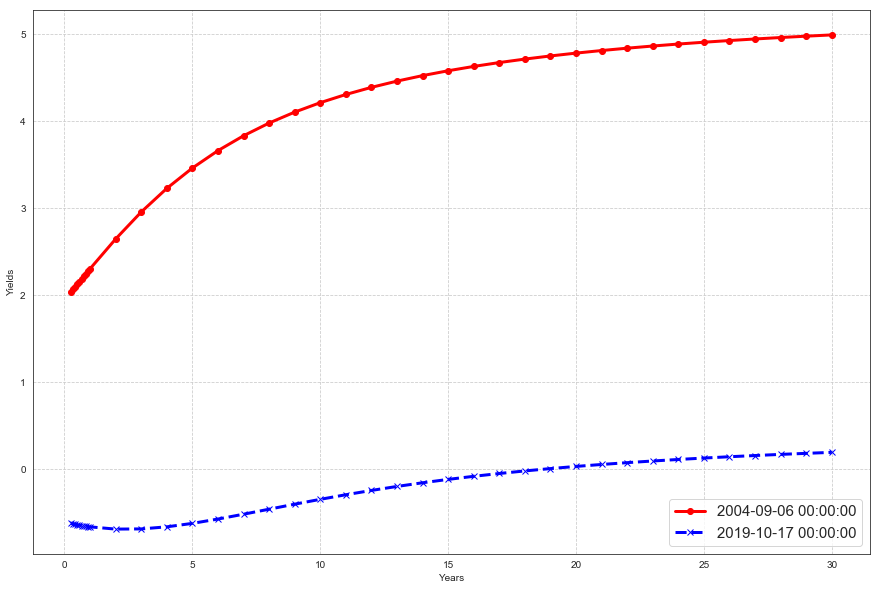

In [114]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(time_float,YC_df.iloc[0],linestyle='-',marker='o',color='r',lw=3)
ax.plot(time_float,YC_df.iloc[-1],linestyle='--',marker='x',color='b',lw=3)
ax.grid(linestyle='--')
ax.legend(loc = 'lower right', frameon=True, fontsize=15)
ax.set_xlabel('Years')
ax.set_ylabel('Yields');

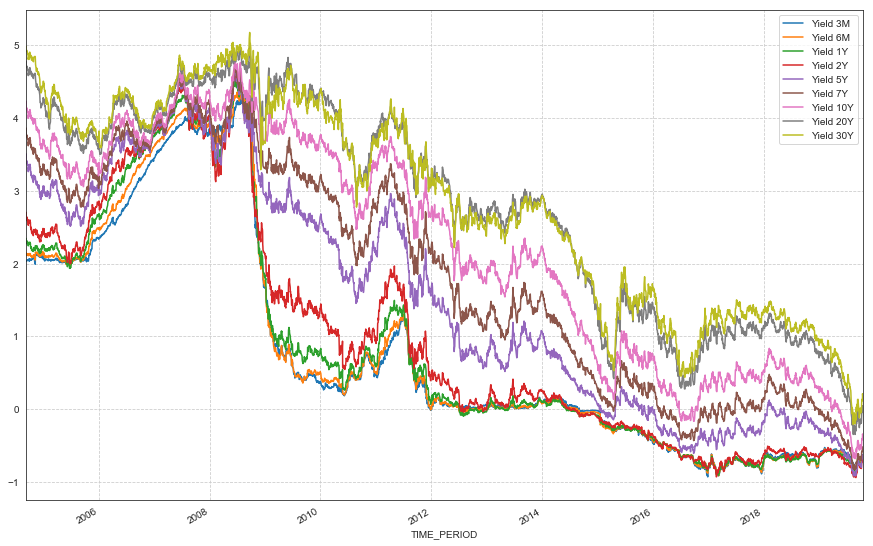

In [115]:
YC_df[['Yield 3M','Yield 6M','Yield 1Y','Yield 2Y','Yield 5Y',
           'Yield 7Y','Yield 10Y','Yield 20Y','Yield 30Y']].plot(figsize=(15,10))
plt.grid(linestyle='--')

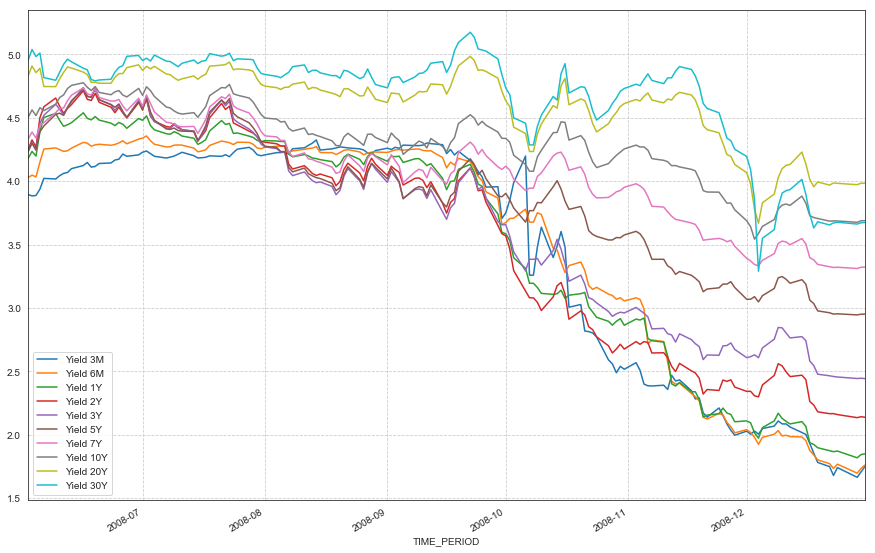

In [118]:
YC_df[['Yield 3M','Yield 6M','Yield 1Y','Yield 2Y','Yield 3Y',
           'Yield 5Y','Yield 7Y','Yield 10Y','Yield 20Y','Yield 30Y']]['2008-06':'2008-12'].plot(figsize=(15,10))
plt.grid(linestyle='--')

### 4- Export the dataset in a csv file

In [119]:
# Save the dataset in csv:
YC_df.to_csv('YC_dataset.csv')